# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [6]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [10]:
!labelme

2024-01-16 11:55:54,187 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Shreyas Joshi\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [5]:
import tensorflow as tf 
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU') 

[]

### 2.3 Load Image into TF Data Pipeline

In [8]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [9]:
images.as_numpy_iterator().next()

b'data\\images\\6df124fa-b42c-11ee-84a1-baf53be06154.jpg'

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[175, 175, 177],
        [175, 175, 177],
        [174, 174, 176],
        ...,
        [224, 225, 227],
        [223, 224, 226],
        [223, 224, 226]],

       [[178, 178, 180],
        [177, 177, 179],
        [177, 177, 179],
        ...,
        [224, 225, 227],
        [224, 225, 227],
        [224, 225, 227]],

       [[181, 181, 183],
        [180, 180, 182],
        [180, 180, 182],
        ...,
        [224, 225, 227],
        [224, 225, 227],
        [224, 225, 227]],

       ...,

       [[168, 169, 163],
        [170, 171, 163],
        [168, 169, 161],
        ...,
        [ 73,  77,  88],
        [ 74,  78,  89],
        [ 73,  77,  88]],

       [[167, 166, 162],
        [166, 165, 160],
        [165, 164, 159],
        ...,
        [ 73,  77,  88],
        [ 72,  76,  87],
        [ 73,  77,  88]],

       [[167, 166, 162],
        [163, 162, 158],
        [162, 161, 156],
        ...,
        [ 77,  81,  92],
        [ 74,  78,  89],
        [ 72,  76,  87]]

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

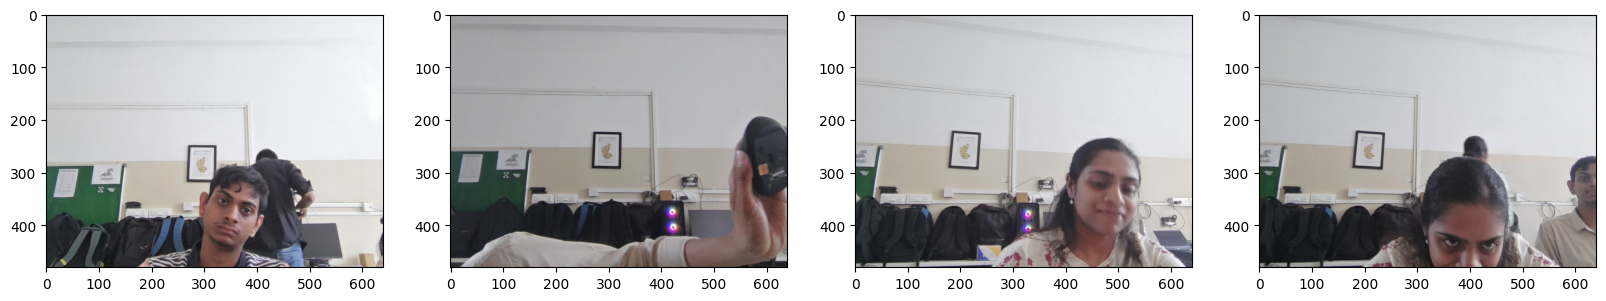

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 75 to train

In [66]:
90*.15 # 22 and 20 to test and val

13.5

### 3.2 Move the Matching Labels

In [25]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [17]:

import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [19]:
img = cv2.imread(os.path.join('data','train', 'images','6a378eaa-b42c-11ee-a651-baf53be06154.jpg'))

In [20]:
with open(os.path.join('data', 'train', 'labels', '6a378eaa-b42c-11ee-a651-baf53be06154.json'), 'r') as f:
    label = json.load(f)

In [21]:
label['shapes'][0]['points']

[[54.16666666666666, 172.7777777777778],
 [298.05555555555554, 466.6666666666667]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [22]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [23]:
coords

[54.16666666666666, 172.7777777777778, 298.05555555555554, 466.6666666666667]

In [24]:
coords = list(np.divide(coords, [640,480,640,480])) #640 and 480 are for my data
# For other size use height and width of image respectively

In [25]:
coords

[0.08463541666666666,
 0.3599537037037038,
 0.4657118055555555,
 0.9722222222222222]

### 4.4 Apply Augmentations and View Results

In [26]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [27]:
augmented['bboxes'][0][2:]

(0.515679012345679, 0.662716049382716)

In [28]:
augmented['bboxes']

[(0.0, 0.009629629629629544, 0.515679012345679, 0.662716049382716)]

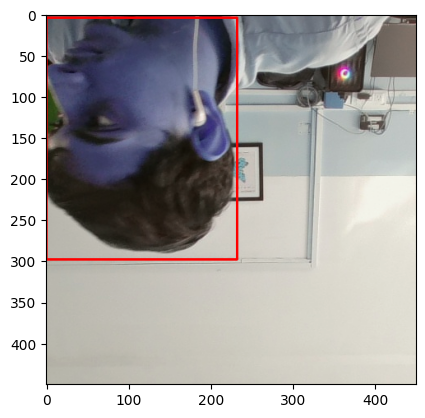

In [29]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)
plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [30]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

KeyboardInterrupt: 

In [31]:
type(train_images)

NameError: name 'train_images' is not defined

### 5.2 Load Augmented Images to Tensorflow Dataset

In [32]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [33]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [34]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [35]:
train_images.as_numpy_iterator().next()

array([[[0.80692405, 0.8030025 , 0.8226103 ],
        [0.8063725 , 0.8102941 , 0.82598037],
        [0.8132353 , 0.81715685, 0.8328431 ],
        ...,
        [0.752451  , 0.74852943, 0.7681373 ],
        [0.7490196 , 0.74509805, 0.7647059 ],
        [0.74417895, 0.7402574 , 0.7598652 ]],

       [[0.8109069 , 0.80735296, 0.826777  ],
        [0.8151961 , 0.81911767, 0.83480394],
        [0.8088235 , 0.8127451 , 0.82843137],
        ...,
        [0.7563726 , 0.7563726 , 0.7642157 ],
        [0.7529412 , 0.7529412 , 0.7607843 ],
        [0.74699754, 0.74699754, 0.7548407 ]],

       [[0.8117647 , 0.8156863 , 0.83137256],
        [0.8152574 , 0.81917894, 0.8348652 ],
        [0.8117647 , 0.8156863 , 0.83137256],
        ...,
        [0.7392157 , 0.7392157 , 0.7470588 ],
        [0.7318627 , 0.7318627 , 0.73970586],
        [0.73811275, 0.73811275, 0.7459559 ]],

       ...,

       [[0.4708946 , 0.46648285, 0.4601103 ],
        [0.499326  , 0.49540442, 0.4875613 ],
        [0.4802696 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [96]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [97]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [98]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [99]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [100]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [101]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4500, 4500, 1320, 1320, 1200, 1200)

### 7.2 Create Final Datasets (Images/Labels)

In [102]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [103]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [104]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [105]:
train.as_numpy_iterator().next()[1]

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} JSONDecodeError: Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Temp\ipykernel_15556\233515788.py", line 3, in load_labels
    label = json.load(f)
            ^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\__init__.py", line 293, in load
    return loads(fp.read(),
           ^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None

json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

### 7.3 View Images and Annotations

In [78]:
data_samples = train.as_numpy_iterator()

In [47]:
res = data_samples.next()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} JSONDecodeError: Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Temp\ipykernel_15556\233515788.py", line 3, in load_labels
    label = json.load(f)
            ^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\__init__.py", line 293, in load
    return loads(fp.read(),
           ^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None

json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

NameError: name 'res' is not defined

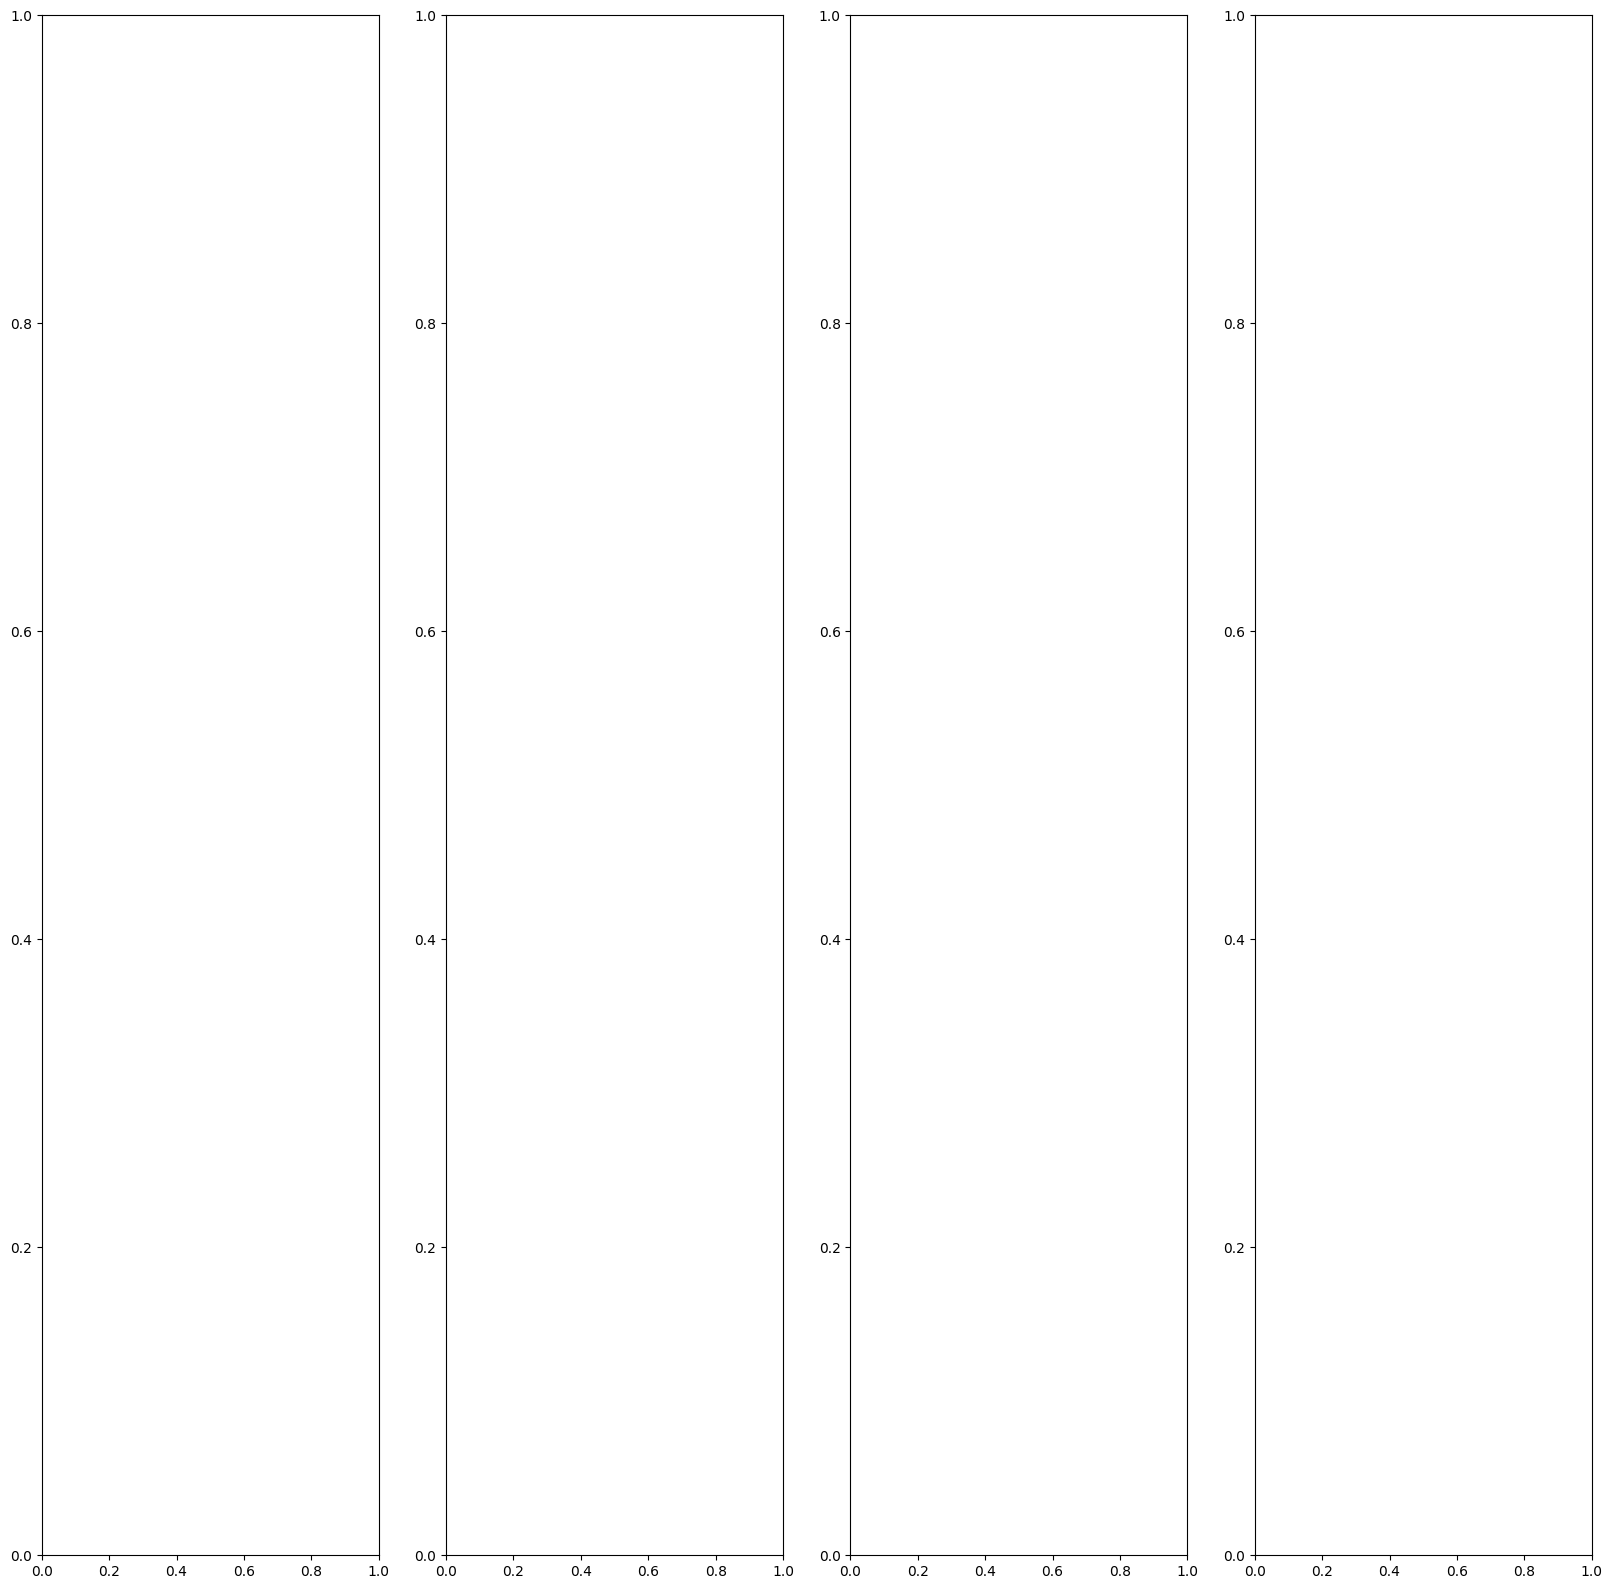

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [50]:

vgg = VGG16(include_top=False)

In [51]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [70]:
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications import mobilenet_v2.MobileNetV2



### 8.3 Build instance of Network

In [84]:
def build_model(): 
    input_layer = Input(shape=(224,224,3))

    mobilenet=MobileNetV2(include_top=False,input_shape=(224,224,3))(input_layer)
    # vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(mobilenet)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(mobilenet)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [85]:
facetracker = build_model()

In [86]:
facetracker.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_11[0][0]']            
 tional)                                                                                          
                                                                                                  
 global_max_pooling2d_6 (Gl  (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
 obalMaxPooling2D)                                                                                
                                                                                            

In [87]:
X, y = train.as_numpy_iterator().next()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} JSONDecodeError: Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Temp\ipykernel_15556\233515788.py", line 3, in load_labels
    label = json.load(f)
            ^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\__init__.py", line 293, in load
    return loads(fp.read(),
           ^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Shreyas Joshi\AppData\Local\Programs\Python\Python311\Lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None

json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [88]:
X.shape

NameError: name 'X' is not defined

In [151]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [152]:
classes, coords

(array([[0.4782347 ],
        [0.50248426],
        [0.5469141 ],
        [0.5640675 ],
        [0.49052346],
        [0.48253787],
        [0.49854875],
        [0.46246994]], dtype=float32),
 array([[0.5771593 , 0.3996875 , 0.49794626, 0.6918194 ],
        [0.54342175, 0.3808577 , 0.5863354 , 0.76319826],
        [0.5460131 , 0.39696094, 0.4055608 , 0.7363008 ],
        [0.51327634, 0.39158922, 0.4148673 , 0.7652112 ],
        [0.4806893 , 0.3555171 , 0.5263098 , 0.75455105],
        [0.5196122 , 0.37894475, 0.46399134, 0.76117   ],
        [0.5190027 , 0.4688347 , 0.3872665 , 0.7426208 ],
        [0.54873466, 0.37117425, 0.47656456, 0.67595845]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [154]:
len(train)

563

In [157]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [159]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [112]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 9.2 Create Localization Loss and Classification Loss

In [161]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [162]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [163]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.6448207>

In [164]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6590718>

In [165]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.6448207>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [106]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [107]:
model = FaceTracker(facetracker)

In [108]:
model.compile(opt, classloss, regressloss)

NameError: name 'opt' is not defined

### 10.2 Train

In [169]:
logdir='logs'

In [170]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [171]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
563/563 [==============================] - 689s 1s/step - total_loss: 0.2112 - class_loss: 0.0471 - regress_loss: 0.1876 - val_total_loss: 0.1447 - val_class_loss: 2.0550e-05 - val_regress_loss: 0.1447
Epoch 2/10
563/563 [==============================] - 438s 772ms/step - total_loss: 0.0179 - class_loss: 2.2049e-04 - regress_loss: 0.0178 - val_total_loss: 0.0441 - val_class_loss: 6.9738e-06 - val_regress_loss: 0.0441
Epoch 3/10
563/563 [==============================] - 446s 787ms/step - total_loss: 0.1551 - class_loss: 0.0573 - regress_loss: 0.1264 - val_total_loss: 0.2255 - val_class_loss: 0.0292 - val_regress_loss: 0.2109
Epoch 4/10
563/563 [==============================] - 579s 1s/step - total_loss: 0.0515 - class_loss: 0.0029 - regress_loss: 0.0500 - val_total_loss: 0.0460 - val_class_loss: 7.3154e-05 - val_regress_loss: 0.0459
Epoch 5/10
563/563 [==============================] - 437s 772ms/step - total_loss: 0.0120 - class_loss: 1.2959e-04 - regress_loss: 0.0119 - v

### 10.3 Plot Performance

In [172]:
hist.history

{'total_loss': [0.017010392621159554,
  0.0028037461452186108,
  0.0545971617102623,
  0.013866516761481762,
  0.0010682734427973628,
  0.002233390463516116,
  0.0005448476877063513,
  0.001408134470693767,
  0.002224540803581476,
  0.004397968295961618],
 'class_loss': [0.00019827281357720494,
  6.400614802259952e-05,
  0.016796324402093887,
  1.582529876031913e-05,
  5.066397648079146e-07,
  1.673455335549079e-05,
  1.6391282997574308e-07,
  8.165953659045044e-06,
  3.1292455560105736e-07,
  9.060005140781868e-06],
 'regress_loss': [0.016911257058382034,
  0.002771743107587099,
  0.046199001371860504,
  0.013858604244887829,
  0.0010680201230570674,
  0.002225023228675127,
  0.0005447657313197851,
  0.001404051436111331,
  0.002224384341388941,
  0.004393438342958689],
 'val_total_loss': [0.14470607042312622,
  0.04411359131336212,
  0.22553741931915283,
  0.045952968299388885,
  0.01044529303908348,
  0.026003960520029068,
  0.04650948941707611,
  0.06612182408571243,
  0.0263157933

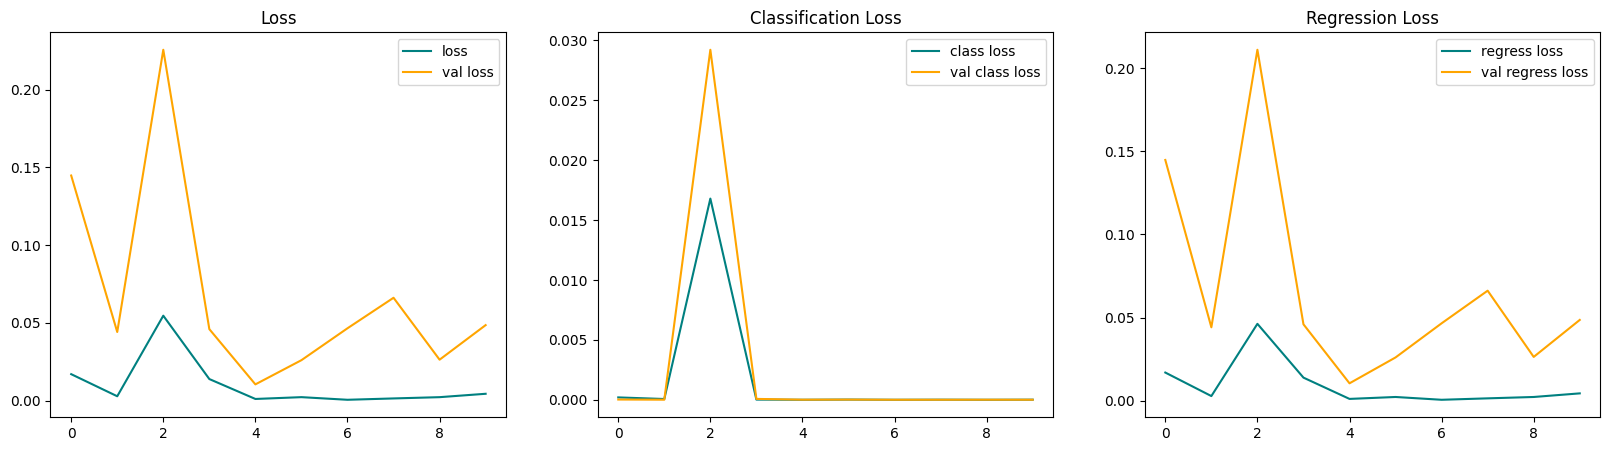

In [173]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [111]:
test_data = test.as_numpy_iterator()

In [175]:
test_sample = test_data.next()

In [110]:
yhat = facetracker.predict(test_sample[0])

NameError: name 'test_sample' is not defined

NameError: name 'test_sample' is not defined

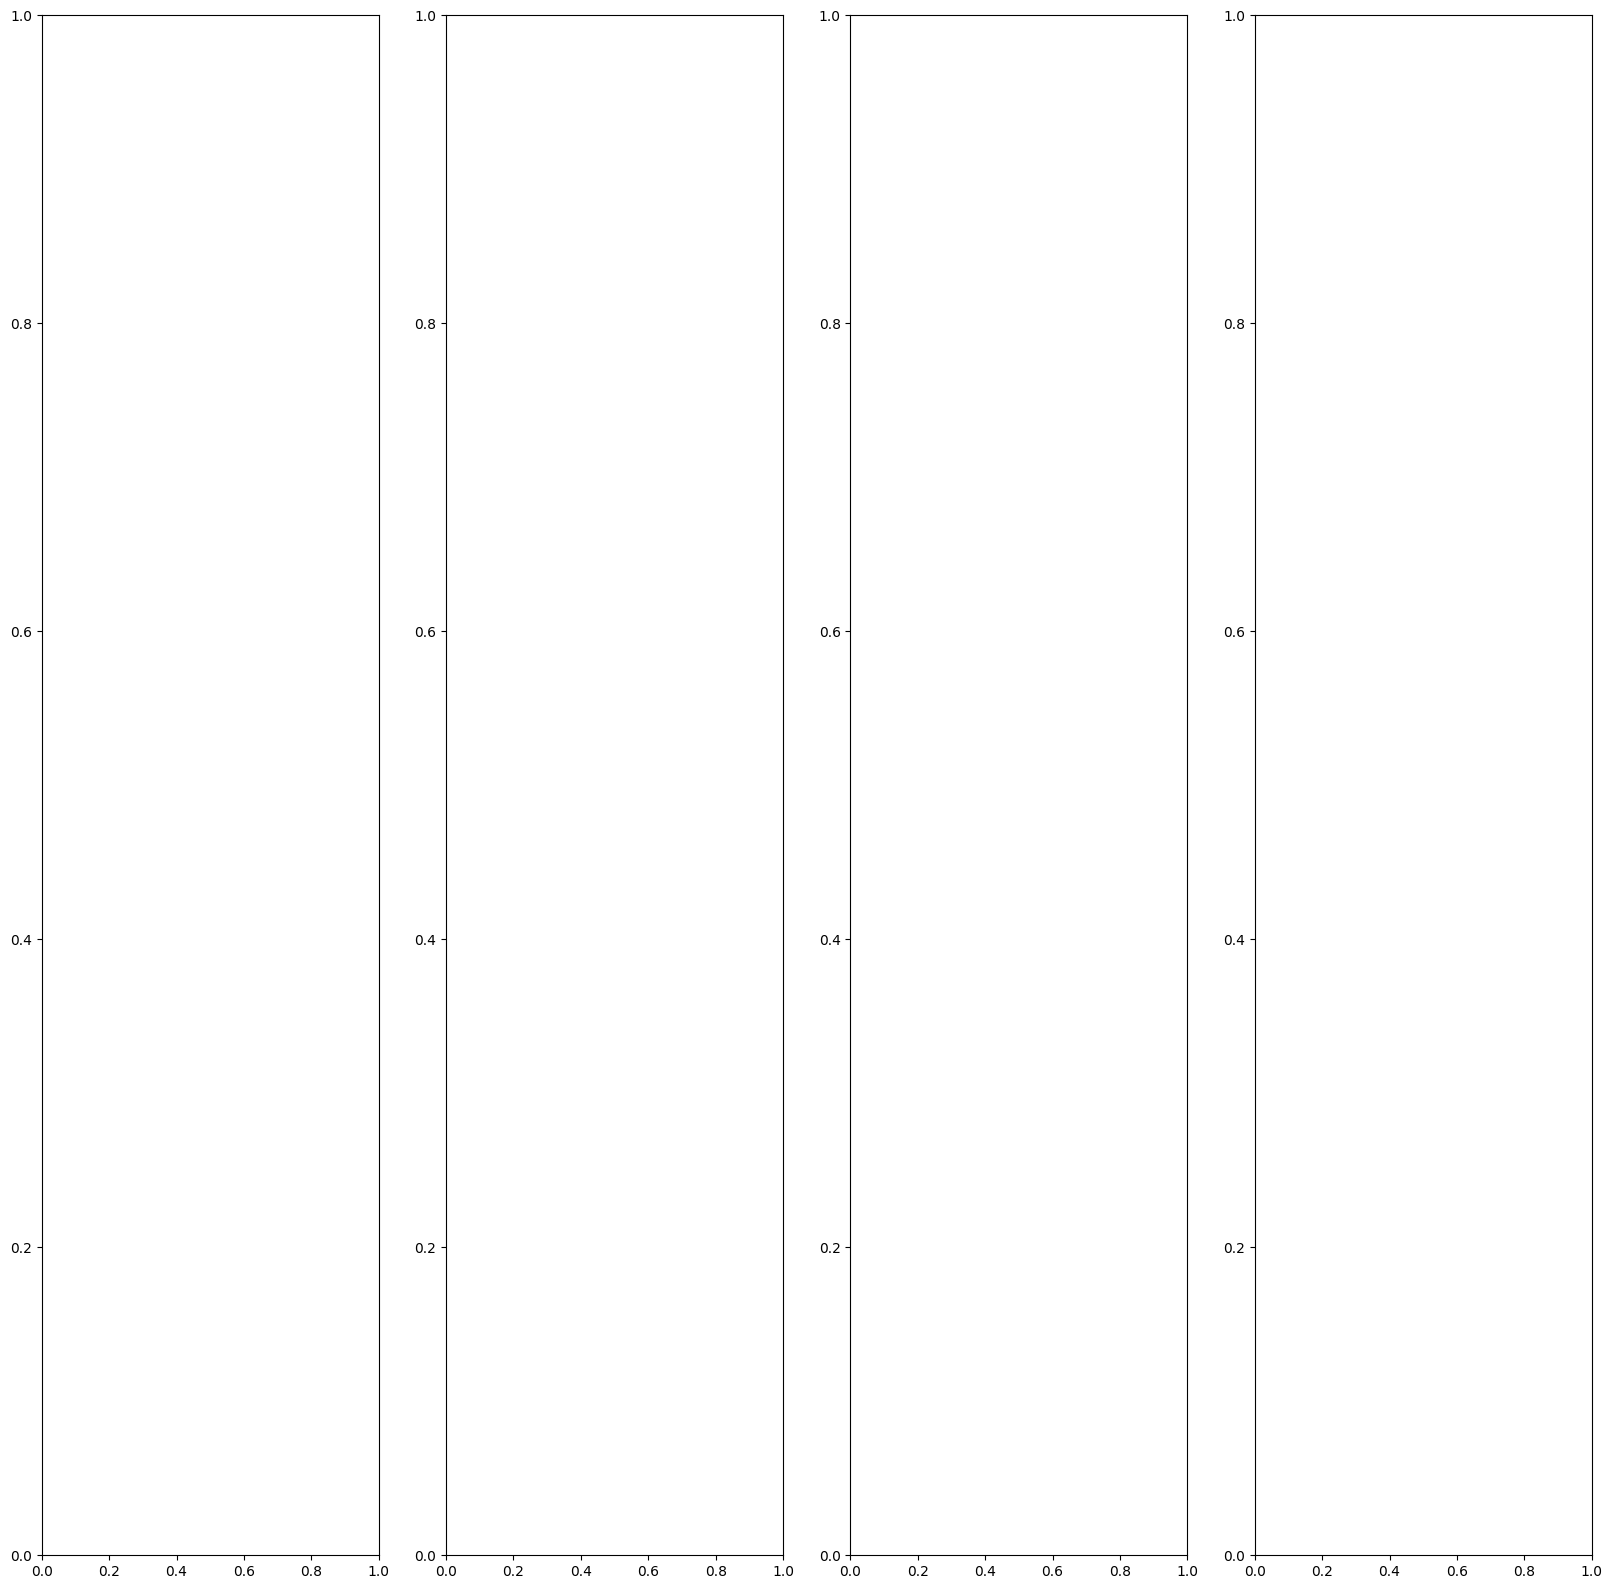

In [109]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [181]:
from tensorflow.keras.models import load_model

In [182]:
facetracker.save('facetracker.h5')

In [183]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 64ms/step
